In [1]:
!git clone https://github.com/Logren777/dataset_drive
!cd dataset_drive

Cloning into 'dataset_drive'...
remote: Enumerating objects: 47766, done.
remote: Total 47766 (delta 0), reused 0 (delta 0), pack-reused 47766bjects:   3% (1433/47766), 3.44 MiB | 2.28 MiB/sReceiving objects:   4% (1996/47766), 4.82 MiB | 2.39 MiB/sReceiving objects:   6% (2866/47766), 6.22 MiB | 2.47 MiB/sReceiving objects:   7% (3513/47766), 7.65 MiB | 2.53 MiB/sReceiving objects:   9% (4299/47766), 9.12 MiB | 2.58 MiB/sReceiving objects:  10% (4823/47766), 9.12 MiB | 2.58 MiB/sReceiving objects:  12% (5732/47766), 12.26 MiB | 2.70 MiB/sReceiving objects:  13% (6238/47766), 12.26 MiB | 2.70 MiB/sReceiving objects:  15% (7165/47766), 15.63 MiB | 2.97 MiB/sReceiving objects:  16% (7643/47766), 15.63 MiB | 2.97 MiB/sReceiving objects:  18% (8598/47766), 19.21 MiB | 3.17 MiB/sReceiving objects:  19% (9149/47766), 19.21 MiB | 3.17 MiB/sReceiving objects:  21% (10031/47766), 23.02 MiB | 3.38 MiB/sReceiving objects:  22% (10881/47766), 23.02 MiB | 3.38 MiB/sReceiving objects:  24% (11464/47

In [6]:
# import os
# dataset = "dataset_drive/dataset"
# dataset = os.listdir(dataset)

In [13]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # convert image to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(96 * 54, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 96 * 54),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = ImageDataset(image_dir='dataset_drive/dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for data in dataloader:
        img = data.view(data.size(0), -1)  # Flatten the image
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the encoder part
torch.save(model.encoder.state_dict(), 'encoder.pth')

# To convert images to 128-dimensional vectors
encoder = model.encoder
encoder.eval()
with torch.no_grad():
    for data in dataloader:
        img = data.view(data.size(0), -1)
        img = img.to(device)
        encoded_imgs = encoder(img)
        print(encoded_imgs.shape)  # Should be (batch_size, 128)


cuda


KeyboardInterrupt: 

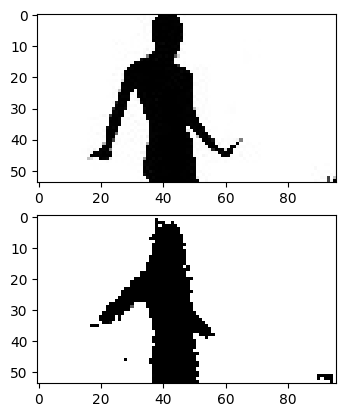

In [12]:
import matplotlib.pyplot as plt
import cv2

test_image = cv2.imread('dataset_drive/dataset/frame20.jpg')

plt.subplot(2,1,1)
plt.imshow(test_image)

test_img_reshaped = torch.from_numpy(test_image[:,:,1]
                     .reshape(96 * 54)
                     .astype(np.float32))
test_img_reshaped = test_img_reshaped.to(device)
predicted = model(test_img_reshaped)

predicted = predicted.cpu().detach()

plt.subplot(2,1,2)
plt.imshow(predicted.reshape(54,96), cmap="gray")

In [ ]:
print(encoded_imgs[0])

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2

# Define and train the RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 128
hidden_size = 256
num_layers = 2
output_size = 128
seq_length = 10

rnn = RNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)

# Prepare the data for RNN
sequences = []
for i in range(len(encoded_imgs) - seq_length):
    seq = encoded_imgs[i:i + seq_length]
    sequences.append(seq)
sequences = torch.stack(sequences)

train_loader = DataLoader(sequences, batch_size=32, shuffle=True)

# Train the RNN
num_epochs = 3500
for epoch in range(num_epochs):
    for seq in train_loader:
        inputs = seq[:, :-1, :]
        targets = seq[:, -1, :]

        outputs = rnn(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate a sequence of vectors
generated_vectors = []
initial_vector = encoded_imgs[0].unsqueeze(0).unsqueeze(0)  # Initial input (batch_size=1, seq_length=1, input_size=128)
generated_vectors.append(initial_vector)



In [ ]:
rnn.eval()
with torch.no_grad():
    for _ in range(100):  # Generate 100 vectors
        next_vector = rnn(initial_vector)
        generated_vectors.append(next_vector)
        initial_vector = next_vector.unsqueeze(0)

# # generated_vectors = torch.cat(generated_vectors).squeeze(1)
# generated_vectors= nn.Embedding(generated_vectors,generated_vectors)
# print(generated_vectors[0])

In [ ]:
# Decode the vectors to images
decoded_images = []

with torch.no_grad():
    for vec in generated_vectors:
        decoded_img = model.decoder(vec)
        decoded_images.append(decoded_img.view(96, 54).cpu().numpy())
# print(decoded_images)
# Convert images to video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
codec = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter('generated_video.mp4', codec, 10, (96, 54), isColor=False)

for img in decoded_images:
    img = (img * 255).astype(np.uint8)
    img = cv2.resize(img, (96, 54))
    print(img)
    video.write(img)

video.release()